## TASK 3 ##

In [154]:
%matplotlib inline
from qiskit import QuantumCircuit
from qiskit.circuit.library import CSwapGate
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit import transpile
from qiskit.circuit.library import CSwapGate
import numpy as np

Figure(705.552x451.5)


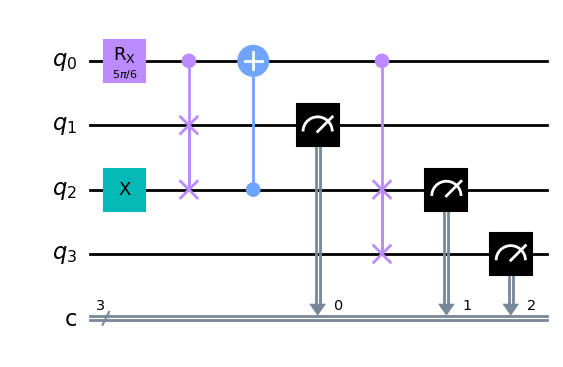

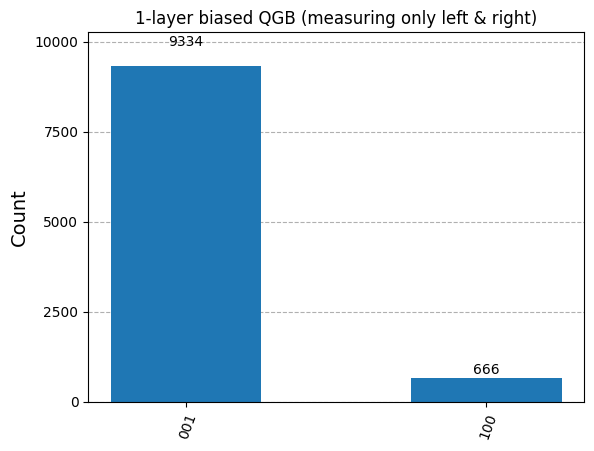

In [155]:

def one_layer_biased_qgb(theta):
    """
    Implements a one-layer biased quantum Galton board as in the provided circuit diagram.
    - theta: bias angle for Rx gate on the coin qubit.
    """
    qc = QuantumCircuit(4, 3)  # q0=coin, q1-q3=positions, 3 classical bits

    # Initialize ball at center position (q2)
    qc.x(2)
    # Initialize coin in |0> (already default)
    # Apply Rx(theta) to coin
    qc.rx(theta, 0)

    # Controlled-SWAP (coin, q1, q2)
    qc.append(CSwapGate(), [0, 1, 2])
    # CNOT (q2, coin)
    qc.cx(2, 0)
    # Controlled-SWAP (coin, q2, q3)
    qc.append(CSwapGate(), [0, 2, 3])

    # Measure position qubits
    qc.measure(1, 0)
    qc.measure(2, 1)
    qc.measure(3, 2)

    # Draw circuit in Clifford style
    print(qc.draw(output='mpl', style='clifford', fold=1))
    return qc

# Example usage:
qc = one_layer_biased_qgb(theta=5 * np.pi / 6)
    
# Simulate
sim = AerSimulator()
from qiskit import transpile
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=10000).result()
counts = result.get_counts()

# Show result
plot_histogram(counts)
plt.title("1-layer biased QGB (measuring only left & right)")
plt.show()

2 layer biased QGB

Figure(1625.27x618.722)


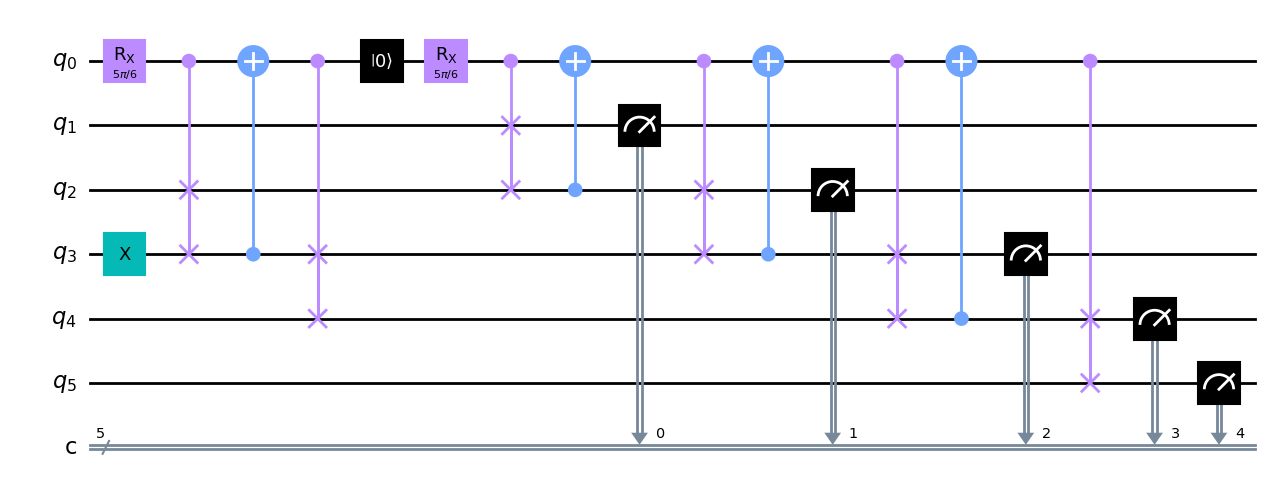

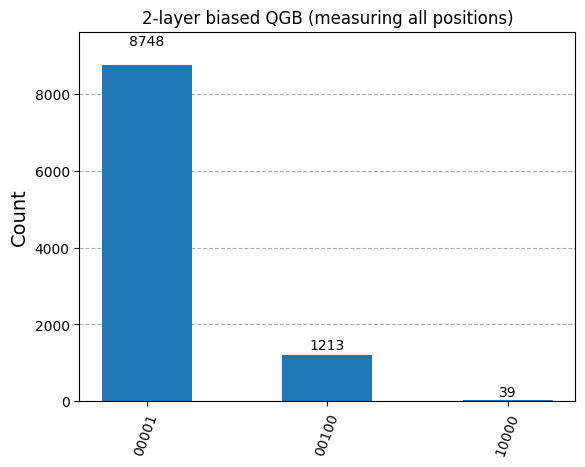

In [156]:
def two_layer_biased_qgb(theta):
    """
    Implements a two-layer biased quantum Galton board.
    - theta: bias angle for Rx gate on the coin qubit.
    """
    qc = QuantumCircuit(6, 5)  # q0=coin, q1-q5=positions, 5 classical bits

    # Initialize ball at center position (q3)
    qc.x(3)
    # Layer 1
    qc.rx(theta, 0)
    qc.append(CSwapGate(), [0, 2, 3])
    qc.cx(3, 0)
    qc.append(CSwapGate(), [0, 3, 4])

    # Reset coin to |0> before layer 2
    qc.reset(0)

    # Layer 2
    qc.rx(theta, 0)
    qc.append(CSwapGate(), [0, 1, 2])
    qc.cx(2, 0)
    qc.append(CSwapGate(), [0, 2, 3])
    qc.cx(3, 0)
    qc.append(CSwapGate(), [0, 3, 4])
    qc.cx(4, 0)
    qc.append(CSwapGate(), [0, 4, 5])

    # Measure position qubits
    qc.measure(1, 0)
    qc.measure(2, 1)
    qc.measure(3, 2)
    qc.measure(4, 3)
    qc.measure(5, 4)

    # Draw circuit in Clifford style
    print(qc.draw(output='mpl', style='clifford', fold=1))
    return qc

# Example usage:
qc = two_layer_biased_qgb(theta=5 * np.pi / 6)

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=10000).result()
counts = result.get_counts()

# Show result
plot_histogram(counts)
plt.title("2-layer biased QGB (measuring all positions)")
plt.show()

n layer biased QGB 

In [ ]:
def n_layer_biased_qgb(n_layers, theta):
    """
    Implements an n-layer biased quantum Galton board.
    - n_layers: number of layers
    - theta: bias angle for Rx gate on the coin qubit.
    """
    num_positions = 2 * n_layers + 1
    total_qubits = num_positions + 1  # 1 coin + position qubits
    qc = QuantumCircuit(total_qubits, num_positions)

    coin = 0
    center = n_layers + 1  # q[index of center position]

    # Initialize ball at center
    qc.x(center)

    for k in range(1, n_layers + 1):
        qc.rx(theta, coin)
        # Pairs for this layer: (center-k) to (center+k-1)
        pairs = [(j, j + 1) for j in range(center - k, center + k)]
        for i, (a, b) in enumerate(pairs):
            qc.append(CSwapGate(), [coin, a, b])
            if i < len(pairs) - 1:
                qc.cx(b, coin)
        # Reset coin to |0> before next layer (unless last layer)
        if k < n_layers:
            qc.reset(coin)

    # Measure all position qubits
    for i, pos in enumerate(range(1, num_positions + 1)):
        qc.measure(pos, i)

    # Draw circuit in Clifford style
    print(qc.draw(output='mpl', style='clifford', fold=1))
    return qc

# Example usage:
qc = n_layer_biased_qgb(n_layers=5, theta=5 * np.pi / 6)

# Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=10000).result()
counts = result.get_counts()

# Show result
plot_histogram(counts)
# plt.title("n-layer biased QGB (measuring all positions)")
plt.title(f"{n_layers}-layer QGB measurement distribution")

plt.show()

Figure(6492.75x1120.39)


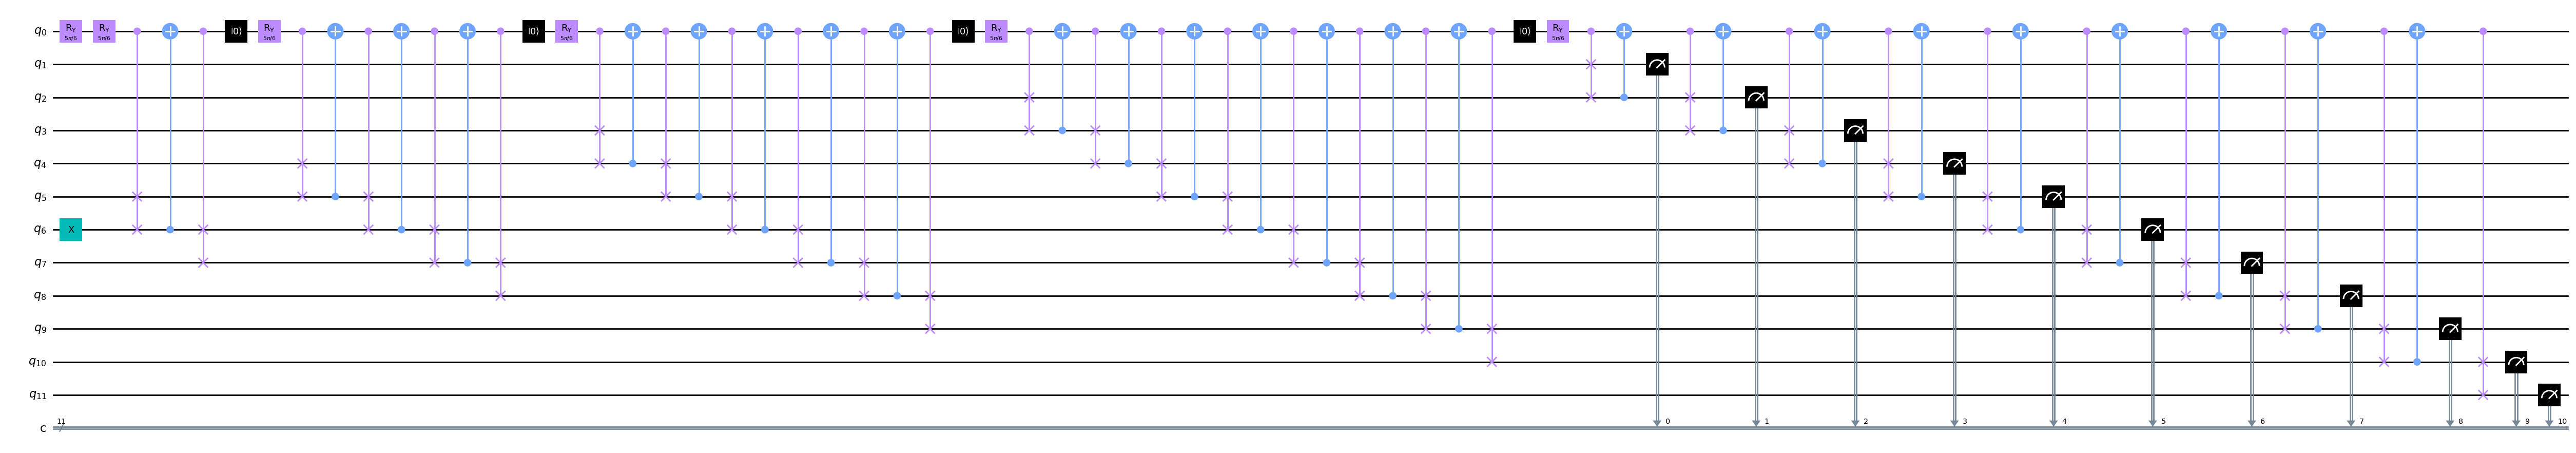

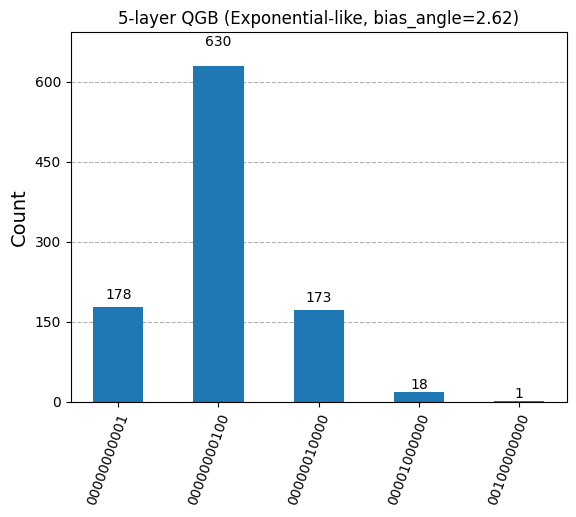

In [ ]:
def build_exponential_qgb(n_layers: int, bias_angle=5 * np.pi / 6, measure_all_positions: bool = True):
    """
    Build an n-layer Quantum Galton Board QGB with a strongly biased coin (to get an exponential-like distribution).
    - bias_angle: angle for RY rotation (smaller angle = more bias to |0>)
    """
    num_positions = 2 * n_layers + 1
    total_qubits = num_positions + 1      # +1 for coin
    qc = QuantumCircuit(total_qubits, num_positions)

    coin = 0
    center = n_layers + 1  # q[index of center position]

    # initialize the ball at center
    qc.x(center)
    # initialize coin in a biased state (strongly favors |0>)
    qc.ry(bias_angle, coin)

    # For each layer k = 1..n_layers
    for k in range(1, n_layers + 1):
        # Apply the same biased coin at each step
        qc.ry(bias_angle, coin)

        # produce list of adjacent pairs (j, j+1) for this layer
        pairs = [(j, j + 1) for j in range(center - k, center + k)]

        # apply cswap(coin, j, j+1) for each pair
        # and inverted CNOT (cx(j+1, coin)) after each cswap except the final one
        for i, (a, b) in enumerate(pairs):
            qc.cswap(coin, a, b)
            if i < len(pairs) - 1:
                qc.cx(b, coin)

        # reset coin to |0> before next layer (unless last layer)
        if k < n_layers:
            qc.reset(coin)

    # Measurements: by default measure all positions q[1..2n+1]
    if measure_all_positions:
        for i, pos in enumerate(range(1, num_positions + 1)):
            qc.measure(pos, i)

    return qc

def simulate_exponential_qgb(n_layers: int, shots: int = 1000, bias_angle=np.pi/12, plot: bool = True):
    qc = build_exponential_qgb(n_layers, bias_angle=bias_angle)
    print(qc.draw(output='mpl', style='clifford', fold=200))  
    
    sim = AerSimulator()
    compiled = transpile(qc, sim)
    job = sim.run(compiled, shots=shots)
    result = job.result()
    counts = result.get_counts()

    if plot:
        plot_histogram(counts)
        plt.title(f"{n_layers}-layer QGB (Exponential-like, bias_angle={bias_angle:.2f})")
        plt.show()

    return qc, counts

# Example usage:
qc, counts = simulate_exponential_qgb(5, shots=1000, bias_angle=5 * np.pi / 6)